# Exploring models - Playground

In [1]:
# start by importing libraries
import pandas as pd
import numpy as np

import joblib
import tempfile
import json
import os
from dotenv import load_dotenv
load_dotenv()

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


In [2]:
# local utils
import sys
sys.path.append('.')

from src.utils import vectorize_ready, predict_and_create_submission

In [71]:
def make_matrices(df, dv=None, fit=False):
    """
    Build X matrix from df using your existing vectorize_ready().
    If fit=True, fit a new DictVectorizer and return it; otherwise reuse dv.
    """
    num_cols = ['curvature']
    cat_cols = ['speed_limit', 'lighting', 'num_reported_accidents', 'weather']

    X_dict = vectorize_ready(df, num_cols=num_cols, cat_cols=cat_cols)

    if fit:
        dv = DictVectorizer(sparse=False)
        X = dv.fit_transform(X_dict)
        return X, dv
    else:
        X = dv.transform(X_dict)
        return X

In [72]:
# preparing for MLflow
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn

# -------------------------------
# SETTINGS
# -------------------------------
EXPERIMENT_NAME = "10_predicting_road_accident_risk"
SEED = 1
RMSE_THRESHOLD = 0.057          # acceptable RMSE based on dummy model
MAX_EVALS = 25                 # number of hyperopt trials
N_JOBS = -1                    # RF parallelism

# ---- Tracking URI from your .env ----
port = os.getenv("MLFLOW_PORT", "5001")

# If notebook runs on HOST use localhost; if inside another container use service name 'mlflow'
candidates = [f"http://localhost:{port}", f"http://mlflow:{port}"]

last_err = None
connected_uri = None
for uri in candidates:
    try:
        mlflow.set_tracking_uri(uri)
        client = MlflowClient()

        # Health check compatible across MLflow versions
        if hasattr(client, "search_experiments"):
            _ = client.search_experiments(max_results=1)
        elif hasattr(client, "list_experiments"):
            _ = client.list_experiments()  # older MLflow
        else:
            # Fallback: try fetching the Default experiment (id "0")
            _ = client.get_experiment_by_name("Default") or client.get_experiment("0")

        connected_uri = uri
        break
    except Exception as e:
        last_err = e

if not connected_uri:
    raise RuntimeError(f"Could not reach MLflow. Last error: {last_err}")

print("Connected to MLflow at:", connected_uri)

# ---- Create/select your experiment ----
mlflow.set_experiment(EXPERIMENT_NAME)
print("Tracking:", mlflow.get_tracking_uri())


# Smoke test
""" with mlflow.start_run(run_name="smoke-test"):
    mlflow.log_param("ok", True)
    mlflow.log_metric("ping", 1.0)
print("Logged a test run.") """


2025/10/13 12:29:18 INFO mlflow.tracking.fluent: Experiment with name '10_predicting_road_accident_risk' does not exist. Creating a new experiment.


Connected to MLflow at: http://localhost:5001
Tracking: http://localhost:5001


' with mlflow.start_run(run_name="smoke-test"):\n    mlflow.log_param("ok", True)\n    mlflow.log_metric("ping", 1.0)\nprint("Logged a test run.") '

### Load the data

In [3]:
# load the data
train_data = pd.read_csv('data/train_split.csv')
test_data = pd.read_csv('data/test_split.csv')

y_train = train_data['accident_risk'].values
y_test = test_data['accident_risk'].values

## Start testing models 

In [74]:
# train a simple tree model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=1)

num_cols = ['curvature']
cat_cols = ['speed_limit', 'lighting', 'num_reported_accidents', 'weather']


y_train = train_data['accident_risk']
X_train_dict = vectorize_ready(train_data, num_cols=num_cols, cat_cols=cat_cols)

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)

rf.fit(X_train, y_train)

# evaluate the model on the train set
y_pred = rf.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
print(f"Train RMSE: {rmse:.3f}")

# evaluate the model on the test set
y_test = test_data['accident_risk']
X_test_dict = vectorize_ready(test_data, num_cols=num_cols, cat_cols=cat_cols)
X_test = dv.transform(X_test_dict)
y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f}")



Train RMSE: 0.055
Test RMSE: 0.057


In [75]:
# -------------------------------
# Hyperopt search space
# -------------------------------
space = {
    "n_estimators":     hp.quniform("n_estimators", 50, 400, 1),
    "max_depth":        hp.pchoice("max_depth", [(0.2, None), (0.8, hp.quniform("md_int", 4, 30, 1))]),
    "min_samples_split":hp.quniform("min_samples_split", 2, 20, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1),
    "max_features":     hp.choice("max_features", ["sqrt", "log2", hp.uniform("max_feat_frac", 0.3, 1.0)]),
    "bootstrap":        hp.choice("bootstrap", [True, False]),
}

def cast_params(p):
    """Hyperopt returns floats for quniform; cast to ints where needed."""
    p = dict(p)
    if isinstance(p["max_depth"], float):
        p["max_depth"] = int(p["max_depth"])
    if p["max_depth"] == 0:     # when pchoice picks 'None' branch, we mapped to 0/None logic
        p["max_depth"] = None
    p["n_estimators"]      = int(p["n_estimators"])
    p["min_samples_split"] = int(p["min_samples_split"])
    p["min_samples_leaf"]  = int(p["min_samples_leaf"])
    
    return p

# -------------------------------
# Objective for hyperopt
# -------------------------------
def objective(params):
    params = cast_params(params)

    with mlflow.start_run(nested=True):
        # Log params
        mlflow.log_params(params)

        # Fresh DV per trial fitted on train only
        X_train, dv = make_matrices(train_data, fit=True)
        X_test = make_matrices(test_data, dv=dv, fit=False)

        # Model
        rf = RandomForestRegressor(
            random_state=SEED,
            n_jobs=N_JOBS,
            **params
        )
        rf.fit(X_train, y_train)

        # Metrics
        rmse_train = root_mean_squared_error(y_train, rf.predict(X_train))
        rmse_test  = root_mean_squared_error(y_test,  rf.predict(X_test))

        mlflow.log_metric("rmse_train", rmse_train)
        mlflow.log_metric("rmse_test", rmse_test)
        mlflow.log_metric("generalization_gap", rmse_test - rmse_train)

        # Conditional export (and log as artifacts)
        if rmse_test <= RMSE_THRESHOLD:
            with tempfile.TemporaryDirectory() as tmp:
                dv_path = os.path.join(tmp, "dv.pkl")
                model_path = os.path.join(tmp, "model.pkl")
                joblib.dump(dv, dv_path)
                joblib.dump(rf, model_path)
                mlflow.log_artifact(dv_path, artifact_path="artifacts")
                mlflow.log_artifact(model_path, artifact_path="artifacts")

                # Optionally log a combined signature via mlflow.sklearn
                mlflow.sklearn.log_model(rf, artifact_path="rf_model")

        # Hyperopt minimizes this:
        return {"loss": rmse_test, "status": STATUS_OK}

# -------------------------------
# Run the search & one “parent” run
# -------------------------------
with mlflow.start_run(run_name="rf_hyperopt_search") as parent_run:
    mlflow.log_param("search_algo", "TPE")
    mlflow.log_param("max_evals", MAX_EVALS)
    mlflow.log_param("seed", SEED)
    mlflow.set_tag("model_family", "RandomForestRegressor")
    mlflow.set_tag("num_cols", num_cols)
    mlflow.set_tag("cat_cols", cat_cols)

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS, trials=trials, rstate=np.random.default_rng(SEED))
    mlflow.log_dict(best, "best_hyperopt_indices.json")

# Report best result mapped back to readable params
def decode_best(best_idx):
    decoded = {
        "n_estimators": int(best_idx["n_estimators"]),
        "max_depth": (None if "md_int" not in best_idx else int(best_idx["md_int"])),
        "min_samples_split": int(best_idx["min_samples_split"]),
        "min_samples_leaf": int(best_idx["min_samples_leaf"]),
        "max_features": ["sqrt", "log2", best_idx.get("max_feat_frac")][best_idx["max_features"]],
        "bootstrap": [True, False][best_idx["bootstrap"]],
    }
    return decoded

print("Best params (decoded):", decode_best(best))

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

2025/10/13 12:30:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-bat-639 at: http://localhost:5001/#/experiments/284535062331422681/runs/dcc26da9cf7b434d9a8356c3ca37f20c.

2025/10/13 12:30:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



  4%|▍         | 1/25 [00:07<02:51,  7.16s/trial, best loss: 0.0959558867259608]

2025/10/13 12:30:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-loon-942 at: http://localhost:5001/#/experiments/284535062331422681/runs/5d177e0014de48778a82b2760ad857d5.

2025/10/13 12:30:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



  8%|▊         | 2/25 [00:24<05:04, 13.25s/trial, best loss: 0.05725339515702595]

2025/10/13 12:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:31:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-fish-491 at: http://localhost:5001/#/experiments/284535062331422681/runs/0a982e2553df4b1c8393a400be0c5ef1.

2025/10/13 12:31:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 12%|█▏        | 3/25 [00:55<07:47, 21.23s/trial, best loss: 0.05646844297740835]

2025/10/13 12:31:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:31:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-asp-960 at: http://localhost:5001/#/experiments/284535062331422681/runs/277c203d885e403b92b554319bc0f37a.

2025/10/13 12:31:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 16%|█▌        | 4/25 [01:27<08:56, 25.57s/trial, best loss: 0.05646844297740835]

2025/10/13 12:32:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-boar-66 at: http://localhost:5001/#/experiments/284535062331422681/runs/d201fa084df2406693218ef2f5df26a6.

2025/10/13 12:32:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 20%|██        | 5/25 [01:34<06:14, 18.70s/trial, best loss: 0.05646844297740835]

2025/10/13 12:32:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:32:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-croc-616 at: http://localhost:5001/#/experiments/284535062331422681/runs/5b562377cf494fbabb8494658800a221.

2025/10/13 12:32:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 24%|██▍       | 6/25 [01:56<06:18, 19.93s/trial, best loss: 0.05646844297740835]

2025/10/13 12:32:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:32:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-tern-855 at: http://localhost:5001/#/experiments/284535062331422681/runs/18cf7943909546b3b096f7bfaf1de774.

2025/10/13 12:32:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 28%|██▊       | 7/25 [02:16<05:57, 19.86s/trial, best loss: 0.05646844297740835]

2025/10/13 12:32:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-deer-802 at: http://localhost:5001/#/experiments/284535062331422681/runs/01fbb77c8c4147c9b5ad22ed906536cd.

2025/10/13 12:32:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 32%|███▏      | 8/25 [02:24<04:35, 16.18s/trial, best loss: 0.05646844297740835]

2025/10/13 12:33:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaptable-mink-363 at: http://localhost:5001/#/experiments/284535062331422681/runs/52e3cb86c7ef4df3854f191619d55a26.

2025/10/13 12:33:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 36%|███▌      | 9/25 [02:37<04:03, 15.19s/trial, best loss: 0.05646844297740835]

2025/10/13 12:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-doe-917 at: http://localhost:5001/#/experiments/284535062331422681/runs/df28a5cce27d43a5b0d4b61dda08c90c.

2025/10/13 12:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 40%|████      | 10/25 [02:54<03:54, 15.64s/trial, best loss: 0.05646844297740835]

2025/10/13 12:33:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:33:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-kit-400 at: http://localhost:5001/#/experiments/284535062331422681/runs/e5a79022fc9f43548d3b2cb8dbed7c5e.

2025/10/13 12:33:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 44%|████▍     | 11/25 [03:16<04:07, 17.69s/trial, best loss: 0.05646844297740835]

2025/10/13 12:33:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-mare-861 at: http://localhost:5001/#/experiments/284535062331422681/runs/06f1a65436444114be8f33663cc08e62.

2025/10/13 12:33:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 48%|████▊     | 12/25 [03:28<03:27, 16.00s/trial, best loss: 0.05646844297740835]

2025/10/13 12:34:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-finch-625 at: http://localhost:5001/#/experiments/284535062331422681/runs/f054375ab286411d8e94350fbe83ebc3.

2025/10/13 12:34:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 52%|█████▏    | 13/25 [03:39<02:53, 14.50s/trial, best loss: 0.05646844297740835]

2025/10/13 12:34:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:34:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-bat-830 at: http://localhost:5001/#/experiments/284535062331422681/runs/d3607d99ab384bbe8e3c5f7822e9a31b.

2025/10/13 12:34:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 56%|█████▌    | 14/25 [03:58<02:55, 15.94s/trial, best loss: 0.05646844297740835]

2025/10/13 12:34:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:34:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-wasp-380 at: http://localhost:5001/#/experiments/284535062331422681/runs/b507148acfd34affbc18c25e8835cf9c.

2025/10/13 12:34:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 60%|██████    | 15/25 [04:09<02:22, 14.25s/trial, best loss: 0.05646844297740835]

2025/10/13 12:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:34:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-bass-25 at: http://localhost:5001/#/experiments/284535062331422681/runs/f8a81d135f7541b3b92e43f18a5c3517.

2025/10/13 12:34:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 64%|██████▍   | 16/25 [04:26<02:16, 15.18s/trial, best loss: 0.05646844297740835]

2025/10/13 12:35:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-moose-104 at: http://localhost:5001/#/experiments/284535062331422681/runs/0c78b387226b472193156e536e88bb24.

2025/10/13 12:35:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 68%|██████▊   | 17/25 [04:39<01:55, 14.40s/trial, best loss: 0.05646844297740835]

2025/10/13 12:35:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-lark-594 at: http://localhost:5001/#/experiments/284535062331422681/runs/0f48b26921fe4cb6ae9092b548494ea8.

2025/10/13 12:35:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 72%|███████▏  | 18/25 [04:50<01:34, 13.54s/trial, best loss: 0.05646844297740835]

2025/10/13 12:35:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:35:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-smelt-635 at: http://localhost:5001/#/experiments/284535062331422681/runs/dde82a18ca2241e9b8355e32dff97121.

2025/10/13 12:35:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 76%|███████▌  | 19/25 [05:19<01:47, 17.99s/trial, best loss: 0.05632354436316157]

2025/10/13 12:36:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:36:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-fowl-760 at: http://localhost:5001/#/experiments/284535062331422681/runs/0e98efe390c242ac8b6697f702b6ca5b.

2025/10/13 12:36:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 80%|████████  | 20/25 [05:32<01:22, 16.48s/trial, best loss: 0.056217451811749586]

2025/10/13 12:36:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:36:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-wren-280 at: http://localhost:5001/#/experiments/284535062331422681/runs/f3a0829388b74950a36570ceb2eae72b.

2025/10/13 12:36:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 84%|████████▍ | 21/25 [05:42<00:59, 14.81s/trial, best loss: 0.056217451811749586]

2025/10/13 12:36:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-vole-662 at: http://localhost:5001/#/experiments/284535062331422681/runs/574ffa83abc94f9ca7db091a37126ad1.

2025/10/13 12:36:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 88%|████████▊ | 22/25 [05:58<00:45, 15.00s/trial, best loss: 0.056217451811749586]

2025/10/13 12:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-bear-924 at: http://localhost:5001/#/experiments/284535062331422681/runs/d319916ed8384a00aed5caf6651ac7c0.

2025/10/13 12:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 92%|█████████▏| 23/25 [06:10<00:27, 14.00s/trial, best loss: 0.056217451811749586]

2025/10/13 12:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:37:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-vole-878 at: http://localhost:5001/#/experiments/284535062331422681/runs/b9f2d5dd4364436baef91364e41eb15a.

2025/10/13 12:37:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 96%|█████████▌| 24/25 [06:33<00:16, 16.88s/trial, best loss: 0.056102217362773585]

2025/10/13 12:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-seal-747 at: http://localhost:5001/#/experiments/284535062331422681/runs/95a521b8bac34958843cc729fb48033a.

2025/10/13 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



100%|██████████| 25/25 [06:50<00:00, 16.42s/trial, best loss: 0.056102217362773585]

2025/10/13 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run rf_hyperopt_search at: http://localhost:5001/#/experiments/284535062331422681/runs/4b68aacf18134fcc8e3b655d5f8fa066.
2025/10/13 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



Best params (decoded): {'n_estimators': 190, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.772149003287071, 'bootstrap': False}


In [76]:
# train a simple  gradient boosting model
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, random_state=1)

num_cols = ['curvature']
cat_cols = ['speed_limit', 'lighting', 'num_reported_accidents', 'weather']


y_train = train_data['accident_risk']
X_train_dict = vectorize_ready(train_data, num_cols=num_cols, cat_cols=cat_cols)

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)

gbr.fit(X_train, y_train)

# evaluate the model on the train set
y_pred = gbr.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
print(f"Train RMSE: {rmse:.3f}")

# evaluate the model on the test set
y_test = test_data['accident_risk']
X_test_dict = vectorize_ready(test_data, num_cols=num_cols, cat_cols=cat_cols)
X_test = dv.transform(X_test_dict)
y_pred = gbr.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)


print(f"Test RMSE: {rmse:.3f}")


Train RMSE: 0.057
Test RMSE: 0.057


In [77]:
# check the features importance
importances = gbr.feature_importances_
feature_names = dv.get_feature_names_out()
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances)

curvature                   0.359168
lighting=night              0.249193
speed_limit=60              0.148073
speed_limit=70              0.143999
weather=clear               0.062509
num_reported_accidents=3    0.033712
num_reported_accidents=4    0.002713
weather=foggy               0.000304
num_reported_accidents=5    0.000198
lighting=daylight           0.000051
weather=rainy               0.000047
speed_limit=45              0.000020
speed_limit=25              0.000008
num_reported_accidents=6    0.000005
lighting=dim                0.000000
num_reported_accidents=2    0.000000
num_reported_accidents=7    0.000000
num_reported_accidents=0    0.000000
num_reported_accidents=1    0.000000
speed_limit=35              0.000000
dtype: float64


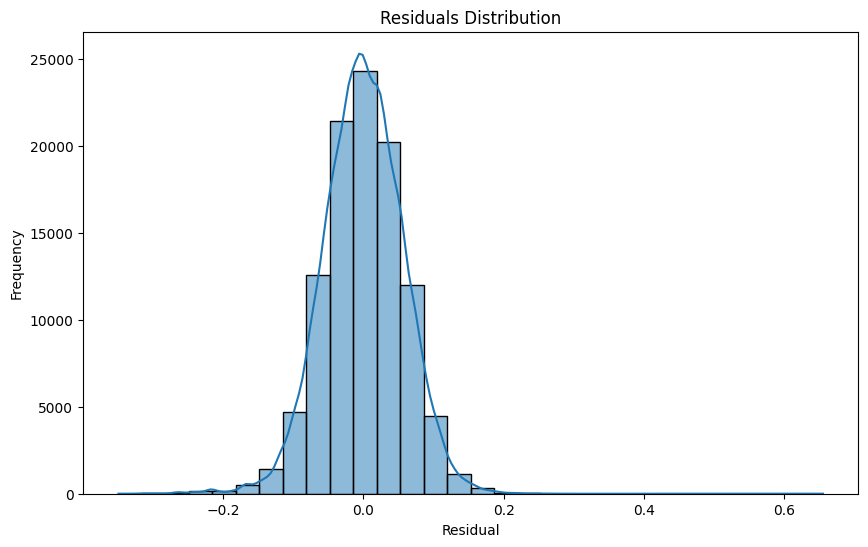

In [78]:
# check the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [81]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import mlflow, tempfile, os, joblib, numpy as np

# -------------------------------
# Hyperopt search space (RMSE-only objective)
# -------------------------------
space = {
    "n_estimators":       hp.quniform("n_estimators", 50, 500, 1),
    "learning_rate":      hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "max_depth":          hp.quniform("max_depth", 2, 8, 1),
    "min_samples_split":  hp.quniform("min_samples_split", 2, 20, 1),
    "min_samples_leaf":   hp.quniform("min_samples_leaf", 1, 10, 1),
    "subsample":          hp.uniform("subsample", 0.5, 1.0),
    "max_features":       hp.choice("max_features", ["sqrt", "log2", hp.uniform("max_feat_frac", 0.3, 1.0), None]),
    # FIX the model's loss; we're optimizing RMSE ourselves:
    # "loss": "squared_error"
}

def cast_params(p):
    p = dict(p)
    p["n_estimators"]      = int(p["n_estimators"])
    p["max_depth"]         = int(p["max_depth"])
    p["min_samples_split"] = int(p["min_samples_split"])
    p["min_samples_leaf"]  = int(p["min_samples_leaf"])
    return p

# -------------------------------
# Objective: minimize RMSE on test
# -------------------------------
def objective(params):
    params = cast_params(params)
    params_for_model = {
        **params,
        "loss": "squared_error",   # locked; metric is RMSE
        "random_state": SEED,
    }

    with mlflow.start_run(nested=True):
        mlflow.log_params(params_for_model)

        X_train, dv = make_matrices(train_data, fit=True)
        X_test = make_matrices(test_data, dv=dv, fit=False)

        gbr = GradientBoostingRegressor(**params_for_model)
        gbr.fit(X_train, y_train)

        rmse_train = root_mean_squared_error(y_train, gbr.predict(X_train))
        rmse_test  = root_mean_squared_error(y_test,  gbr.predict(X_test))

        mlflow.log_metric("rmse_train", rmse_train)
        mlflow.log_metric("rmse_test", rmse_test)
        mlflow.log_metric("generalization_gap", rmse_test - rmse_train)

        if rmse_test <= RMSE_THRESHOLD:
            with tempfile.TemporaryDirectory() as tmp:
                dv_path = os.path.join(tmp, "dv.pkl")
                model_path = os.path.join(tmp, "model.pkl")
                joblib.dump(dv, dv_path)
                joblib.dump(gbr, model_path)
                mlflow.log_artifact(dv_path, artifact_path="artifacts")
                mlflow.log_artifact(model_path, artifact_path="artifacts")
                mlflow.sklearn.log_model(gbr, artifact_path="gbr_model")

        # Hyperopt MINIMIZES this:
        return {"loss": rmse_test, "status": STATUS_OK}

# -------------------------------
# Run search under a parent run
# -------------------------------
with mlflow.start_run(run_name="gbr_hyperopt_search_rmse") as parent_run:
    mlflow.log_param("search_algo", "TPE")
    mlflow.log_param("max_evals", MAX_EVALS)
    mlflow.log_param("seed", SEED)
    mlflow.set_tag("model_family", "GradientBoostingRegressor")
    mlflow.set_tag("num_cols", num_cols)
    mlflow.set_tag("cat_cols", cat_cols)

    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=MAX_EVALS,
        trials=trials,
        rstate=np.random.default_rng(SEED)
    )
    mlflow.log_dict(best, "best_hyperopt_indices.json")

# -------------------------------
# Decode best (indices -> readable)
# -------------------------------
def decode_best(best_idx):
    max_feat_options = ["sqrt", "log2", best_idx.get("max_feat_frac"), None]
    return {
        "n_estimators":      int(best_idx["n_estimators"]),
        "learning_rate":     float(best_idx["learning_rate"]),
        "max_depth":         int(best_idx["max_depth"]),
        "min_samples_split": int(best_idx["min_samples_split"]),
        "min_samples_leaf":  int(best_idx["min_samples_leaf"]),
        "subsample":         float(best_idx["subsample"]),
        "max_features":      max_feat_options[best_idx["max_features"]],
        "loss":              "squared_error",  # fixed
    }

print("Best params (decoded):", decode_best(best))


  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

2025/10/13 13:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:02:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-hawk-782 at: http://localhost:5001/#/experiments/284535062331422681/runs/fc80b5e9c2f449658572114ca4a90e63.

2025/10/13 13:02:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



  4%|▍         | 1/25 [00:50<20:17, 50.72s/trial, best loss: 0.05600435724442567]

2025/10/13 13:08:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:08:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-shoat-481 at: http://localhost:5001/#/experiments/284535062331422681/runs/49f00d585b834c1e8a784b0b58791785.

2025/10/13 13:08:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



  8%|▊         | 2/25 [06:01<1:18:07, 203.79s/trial, best loss: 0.05600435724442567]

2025/10/13 13:10:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:10:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-colt-420 at: http://localhost:5001/#/experiments/284535062331422681/runs/7f3382e89b4e4ca8bec7346e52612e79.

2025/10/13 13:10:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 12%|█▏        | 3/25 [08:27<1:05:00, 177.29s/trial, best loss: 0.05584129573188643]

2025/10/13 13:14:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:14:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-snake-150 at: http://localhost:5001/#/experiments/284535062331422681/runs/e28a092ccfa348ac8596bd8a6ecd9bc7.

2025/10/13 13:14:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 16%|█▌        | 4/25 [12:03<1:07:25, 192.63s/trial, best loss: 0.05584129573188643]

2025/10/13 13:16:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:16:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run capable-sheep-128 at: http://localhost:5001/#/experiments/284535062331422681/runs/0f80d91d2276441ca33f4a134f4dea2f.

2025/10/13 13:16:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 20%|██        | 5/25 [14:06<55:46, 167.34s/trial, best loss: 0.05584129573188643]  

2025/10/13 13:18:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:18:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-grub-343 at: http://localhost:5001/#/experiments/284535062331422681/runs/5447c0c64667454ab31bedb6a337b917.

2025/10/13 13:18:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 24%|██▍       | 6/25 [16:01<47:23, 149.67s/trial, best loss: 0.05584129573188643]

2025/10/13 13:19:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-hog-112 at: http://localhost:5001/#/experiments/284535062331422681/runs/2891b62fe3c94003beddfa25b7389451.

2025/10/13 13:19:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 28%|██▊       | 7/25 [17:07<36:41, 122.29s/trial, best loss: 0.05584129573188643]

2025/10/13 13:21:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:21:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-mare-877 at: http://localhost:5001/#/experiments/284535062331422681/runs/50c10e0bcacd46e88c934b375e9d0389.

2025/10/13 13:21:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 32%|███▏      | 8/25 [18:56<33:27, 118.07s/trial, best loss: 0.05584129573188643]

2025/10/13 13:24:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:24:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-kite-651 at: http://localhost:5001/#/experiments/284535062331422681/runs/a4a671dcc34944c09ac350d13d2d058c.

2025/10/13 13:24:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 36%|███▌      | 9/25 [22:05<37:22, 140.18s/trial, best loss: 0.055753106850334015]

2025/10/13 13:25:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-shrimp-607 at: http://localhost:5001/#/experiments/284535062331422681/runs/f6b115df31264638b0c044e44c7de735.

2025/10/13 13:25:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 40%|████      | 10/25 [22:59<28:25, 113.73s/trial, best loss: 0.055753106850334015]

2025/10/13 13:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:26:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaptable-grouse-210 at: http://localhost:5001/#/experiments/284535062331422681/runs/632915ebc655475b9e597ec65221b078.

2025/10/13 13:26:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 44%|████▍     | 11/25 [24:04<23:03, 98.80s/trial, best loss: 0.055753106850334015] 

2025/10/13 13:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:27:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-grub-915 at: http://localhost:5001/#/experiments/284535062331422681/runs/5e7c6ea8c5114e2d977b55c42646ebc0.

2025/10/13 13:27:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 48%|████▊     | 12/25 [25:41<21:16, 98.21s/trial, best loss: 0.055753106850334015]

2025/10/13 13:29:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:29:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-lamb-929 at: http://localhost:5001/#/experiments/284535062331422681/runs/fecb3baaac444b949b491b7d707b6798.

2025/10/13 13:29:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 52%|█████▏    | 13/25 [27:08<18:57, 94.80s/trial, best loss: 0.055753106850334015]

2025/10/13 13:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-asp-631 at: http://localhost:5001/#/experiments/284535062331422681/runs/fae224dd6ce747b4a2dbbe1976aadb31.

2025/10/13 13:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 56%|█████▌    | 14/25 [27:41<13:56, 76.02s/trial, best loss: 0.055753106850334015]

2025/10/13 13:30:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-horse-116 at: http://localhost:5001/#/experiments/284535062331422681/runs/2ee58f7eb0f84e4f8b319dee7d6dc4f5.

2025/10/13 13:30:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 60%|██████    | 15/25 [28:49<12:16, 73.63s/trial, best loss: 0.055753106850334015]

2025/10/13 13:33:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:33:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-conch-643 at: http://localhost:5001/#/experiments/284535062331422681/runs/68d397f9aa4e4a58b66804a2e2789843.

2025/10/13 13:33:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 64%|██████▍   | 16/25 [31:10<14:06, 94.09s/trial, best loss: 0.055753106850334015]

2025/10/13 13:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-crab-306 at: http://localhost:5001/#/experiments/284535062331422681/runs/ce7ef225541d4d89923eef9935482d6e.

2025/10/13 13:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 68%|██████▊   | 17/25 [31:30<09:33, 71.67s/trial, best loss: 0.055753106850334015]

2025/10/13 13:35:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-mare-231 at: http://localhost:5001/#/experiments/284535062331422681/runs/cd202cd061f545f49581baf34160a490.

2025/10/13 13:35:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 72%|███████▏  | 18/25 [33:28<09:58, 85.52s/trial, best loss: 0.055753106850334015]

2025/10/13 13:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:37:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-cat-138 at: http://localhost:5001/#/experiments/284535062331422681/runs/3fda9e77a8de4dd49203fb9e971591f2.

2025/10/13 13:37:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 76%|███████▌  | 19/25 [35:14<09:11, 91.90s/trial, best loss: 0.055753106850334015]

2025/10/13 13:38:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:38:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-cod-497 at: http://localhost:5001/#/experiments/284535062331422681/runs/3610328940084e799d629b1011400c77.

2025/10/13 13:38:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 80%|████████  | 20/25 [36:42<07:32, 90.58s/trial, best loss: 0.055753106850334015]

2025/10/13 13:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:41:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run silent-snail-480 at: http://localhost:5001/#/experiments/284535062331422681/runs/5bf6bf45bcff4b5e812d0cec20bec4d2.

2025/10/13 13:41:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 84%|████████▍ | 21/25 [39:29<07:34, 113.55s/trial, best loss: 0.0557499955986158] 

2025/10/13 13:42:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:42:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-loon-201 at: http://localhost:5001/#/experiments/284535062331422681/runs/3296d9cfbb5149b394c4c71d438bb377.

2025/10/13 13:42:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 88%|████████▊ | 22/25 [40:39<05:01, 100.47s/trial, best loss: 0.0557499955986158]

2025/10/13 13:45:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:45:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-moth-722 at: http://localhost:5001/#/experiments/284535062331422681/runs/8d458ac8133840b0b400f73b0a3f0c2a.

2025/10/13 13:45:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 92%|█████████▏| 23/25 [43:17<03:55, 117.82s/trial, best loss: 0.0557499955986158]

2025/10/13 13:47:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-asp-397 at: http://localhost:5001/#/experiments/284535062331422681/runs/7c97ba0925db4cf2b5d71e0a9b010fbf.

2025/10/13 13:47:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



 96%|█████████▌| 24/25 [44:58<01:52, 112.76s/trial, best loss: 0.0557499955986158]

2025/10/13 13:50:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

2025/10/13 13:50:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-wren-857 at: http://localhost:5001/#/experiments/284535062331422681/runs/6fb670bb80314d028da14bc65659492d.

2025/10/13 13:50:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



100%|██████████| 25/25 [48:04<00:00, 115.38s/trial, best loss: 0.0557499955986158]

2025/10/13 13:50:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run gbr_hyperopt_search_rmse at: http://localhost:5001/#/experiments/284535062331422681/runs/095885547acc4785984635dd72e16d63.
2025/10/13 13:50:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/284535062331422681.



Best params (decoded): {'n_estimators': 191, 'learning_rate': 0.08242627749770964, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.9928138975071765, 'max_features': 0.8642858140264649, 'loss': 'squared_error'}


## Playground: simple tree with feature engineering

In [4]:
# train data

prep_train = train_data

print(prep_train.head())


       id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0  163141     rural          2       0.14           60       dim   rainy   
1  453971     rural          4       0.12           60  daylight   rainy   
2  478569   highway          4       0.72           70  daylight   foggy   
3   17719   highway          3       0.04           25     night   foggy   
4  145471     urban          1       0.85           25       dim   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True     evening     True           True   
1               False        False     morning     True          False   
2               False         True   afternoon    False           True   
3                True        False     morning     True           True   
4               False        False   afternoon    False          False   

   num_reported_accidents  accident_risk          bins  
0                       1           0.33 

In [5]:
# remove bins from prep_train
prep_train = prep_train.drop(columns='bins')

In [55]:
def new_features(X):
    # create category for is_lighting_night
    X["is_lighting_night"] = X["lighting"] == "night"
    # create category is_speed_limit_over_45
    X['is_speed_limit_over_40'] = X["speed_limit"] > 40
    # create category is_speed_limit_over_60
    X['is_speed_limit_over_60'] = X["speed_limit"] >= 60
    # create category is_accidents_over_2
    X['is_accidents_over_2'] = X["num_reported_accidents"] > 2
    # create category is_accidents_over_3
    X['is_accidents_over_3'] = X["num_reported_accidents"] > 3
    

    # additional categories
    X["curv_x_night"] = X["curvature"] * (X["lighting"] == "night").astype(int)
    X["curv_x_spd60"] = X["curvature"] * X["is_speed_limit_over_60"].astype(int)
    X["night_x_spd60"] = (X["lighting"] == "night").astype(int) * X["is_speed_limit_over_60"].astype(int)

    return X

In [56]:
X_train_raw = new_features(train_data)

In [57]:
# set the features we will use
num_features = ['curvature', 'curv_x_night', 'curv_x_spd60','night_x_spd60' ]
cat_features = ['lighting', 'weather']



cat_features = cat_features + ["is_speed_limit_over_40","is_accidents_over_2", "is_speed_limit_over_60"]

In [58]:
# 1. Split the data
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X_train_raw[cat_features+num_features], X_train_raw["accident_risk"], test_size=0.2, random_state=42)

# 2. Define transformers
# numeric_transformer = StandardScaler()   # optional for numeric stability

categorical_transformer = OneHotEncoder(
    drop="first",           # drop one dummy per category → avoids multicollinearity
    handle_unknown="ignore" # handle unseen categories gracefully
)

# 3. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# 4. Build the pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# 5. Fit the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['curvature', 'curv_x_night',
                                                   'curv_x_spd60',
                                                   'night_x_spd60']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['lighting', 'weather',
                                                   'is_speed_limit_over_40',
                                                   'is_accidents_over_2',
                                                   'is_speed_limit_over_60'])])),
                ('regressor', LinearRegression())])

In [59]:
# evaluate the model
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# print RSME test
print(f"RMSE test: {root_mean_squared_error(y_pred_test, y_test)}")
print(f"RMSE train: {root_mean_squared_error(y_pred_train, y_train)}")

RMSE test: 0.057915939804821806
RMSE train: 0.05813293524231905


In [61]:
# 7. Inspect coefficients
feature_names = (
    model.named_steps["preprocessor"]
    .transformers_[0][2] + 
    list(model.named_steps["preprocessor"].transformers_[1][1]
         .get_feature_names_out(cat_features))
)
coefs = model.named_steps["regressor"].coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})
print(coef_df.sort_values("Coefficient", ascending=False))


                        Feature  Coefficient
0                     curvature     0.298345
5                lighting_night     0.185143
10  is_speed_limit_over_60_True     0.181027
9      is_accidents_over_2_True     0.096187
7                 weather_rainy     0.093192
6                 weather_foggy     0.092936
2                  curv_x_spd60     0.009973
1                  curv_x_night     0.008741
3                 night_x_spd60     0.002428
4                  lighting_dim     0.002208
8   is_speed_limit_over_40_True    -0.000780


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_train_raw[cat_features+num_features], X_train_raw["accident_risk"], test_size=0.2, random_state=42)

# 2. Define transformers
# numeric_transformer = StandardScaler()   # optional for numeric stability

categorical_transformer = OneHotEncoder(
    drop="first",           # drop one dummy per category → avoids multicollinearity
    handle_unknown="ignore" # handle unseen categories gracefully
)

# 3. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# 4. Build the pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("randomForest", RandomForestRegressor(n_estimators=50, random_state=42))
])

# 5. Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['curvature', 'curv_x_night',
                                                   'curv_x_spd60',
                                                   'night_x_spd60']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['lighting', 'weather',
                                                   'is_speed_limit_over_40',
                                                   'is_accidents_over_2',
                                                   'is_speed_limit_over_60'])])),
                ('randomForest',
                 RandomForestRegressor(n_estimators=50, random_state=42))])

In [63]:
# evaluate the model
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# print RSME test
print(f"RMSE test: {root_mean_squared_error(y_pred_test, y_test)}")
print(f"RMSE train: {root_mean_squared_error(y_pred_train, y_train)}")

RMSE test: 0.056346632334340514
RMSE train: 0.05580589349358211


In [64]:
# 1) Get the post-encoding feature names in the correct order
pre = model.named_steps["preprocessor"]
feature_names = pre.get_feature_names_out()  # e.g. ["num__curvature", "cat__weather=rain", ...]

# 2) Get impurity importances from the forest
rf = model.named_steps["randomForest"]          # or ["model"] if you named it that way
importances = rf.feature_importances_

# 3) Make a tidy table
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print(imp_df.sort_values("Importance", ascending=False).head(20))


                             Feature  Importance
2                  num__curv_x_spd60    0.443692
1                  num__curv_x_night    0.225505
0                     num__curvature    0.113543
5                cat__lighting_night    0.061513
6                 cat__weather_foggy    0.042838
9      cat__is_accidents_over_2_True    0.042499
7                 cat__weather_rainy    0.031097
3                 num__night_x_spd60    0.021848
10  cat__is_speed_limit_over_60_True    0.016256
4                  cat__lighting_dim    0.000612
8   cat__is_speed_limit_over_40_True    0.000598


In [65]:
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

def base_feature(name: str) -> str:
    if "__" in name:  # strip transformer prefix
        name = name.split("__", 1)[1]
    return name.split("=", 1)[0]  # strip OHE value

imp_df["Group"] = imp_df["Feature"].map(base_feature)
group_imp = (imp_df.groupby("Group", as_index=False)["Importance"]
                  .sum()
                  .sort_values("Importance", ascending=False))
print(group_imp)

                          Group  Importance
1                  curv_x_spd60    0.443692
0                  curv_x_night    0.225505
2                     curvature    0.113543
7                lighting_night    0.061513
9                 weather_foggy    0.042838
3      is_accidents_over_2_True    0.042499
10                weather_rainy    0.031097
8                 night_x_spd60    0.021848
5   is_speed_limit_over_60_True    0.016256
6                  lighting_dim    0.000612
4   is_speed_limit_over_40_True    0.000598


### Playground - Random Forest 🌳

In [ ]:
# set the features we will use
num_features = ['curvature']
cat_features = ['lighting', 'weather']

cat_features = cat_features + ["is_speed_limit_over_45","is_accidents_over_2",]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(prep_train[cat_features+num_features], prep_train["accident_risk"], test_size=0.2, random_state=42)

# 2. Define transformers
# numeric_transformer = StandardScaler()   # optional for numeric stability

categorical_transformer = OneHotEncoder(
    drop="first",           # drop one dummy per category → avoids multicollinearity
    handle_unknown="ignore" # handle unseen categories gracefully
)

# 3. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# 4. Build the pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("randomForest", RandomForestRegressor(n_estimators=50, random_state=42))
])

# 5. Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['curvature']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['lighting', 'weather',
                                                   'is_speed_limit_over_45',
                                                   'is_accidents_over_2',
                                                   'is_accidents_over_3'])])),
                ('randomForest',
                 RandomForestRegressor(n_estimators=50, random_state=42))])

In [22]:
# evaluate the model
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# print RSME test
print(f"RMSE test: {root_mean_squared_error(y_pred_test, y_test)}")
print(f"RMSE train: {root_mean_squared_error(y_pred_train, y_train)}")

RMSE test: 0.05632032003292068
RMSE train: 0.05584255490567553


In [23]:
pre = model.named_steps["preprocessor"]
feature_names = pre.get_feature_names_out()  # e.g. ["num__curvature", "cat__weather=rain", ...]

# 2) Get impurity importances from the forest
rf = model.named_steps["randomForest"]          # or ["model"] if you named it that way
importances = rf.feature_importances_

# 3) Make a tidy table
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print(imp_df.sort_values("Importance", ascending=False).head(20))


                            Feature  Importance
0                    num__curvature    0.367455
2               cat__lighting_night    0.267077
5  cat__is_speed_limit_over_45_True    0.252047
3                cat__weather_foggy    0.043256
6     cat__is_accidents_over_2_True    0.039016
4                cat__weather_rainy    0.030188
1                 cat__lighting_dim    0.000531
7     cat__is_accidents_over_3_True    0.000430


In [24]:
def create_submission_file(test_data, y_pred, filename='submission.csv'):
    submission = pd.DataFrame({
        'id': test_data['id'],
        'accident_risk': np.round(y_pred, 3)
    })
    submission.to_csv(filename, index=False)
    print(f"Submission file '{filename}' created.")

In [25]:
kaggle_test = pd.read_csv('data/test.csv')

In [27]:
kaggle_test = new_features(kaggle_test)

In [ ]:
kaggle_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,is_lighting_night,is_speed_limit_over_45,is_accidents_over_2,is_accidents_over_3
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1,True,False,False,False
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0,False,False,False,False
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1,False,False,False,False
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2,False,False,False,False
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3,False,False,True,False


In [29]:
predict_kaggle = model.predict(kaggle_test[cat_features+num_features])

In [30]:
create_submission_file(kaggle_test, predict_kaggle, filename='submission_kaggle.csv')

Submission file 'submission_kaggle.csv' created.


### Playground GBR

In [83]:
X_train_raw

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,...,is_speed_limit_over_45,is_accidents_over_2,is_accidents_over_3,curv_x_night,curv_x_spd45,night_x_spd45,is_speed_limit_over_40,is_speed_limit_over_60,curv_x_spd60,night_x_spd60
0,163141,rural,2,0.14,60,dim,rainy,False,True,evening,...,True,False,False,0.00,0.14,0,True,True,0.14,0
1,453971,rural,4,0.12,60,daylight,rainy,False,False,morning,...,True,False,False,0.00,0.12,0,True,True,0.12,0
2,478569,highway,4,0.72,70,daylight,foggy,False,True,afternoon,...,True,False,False,0.00,0.72,0,True,True,0.72,0
3,17719,highway,3,0.04,25,night,foggy,True,False,morning,...,False,False,False,0.04,0.00,0,False,False,0.00,0
4,145471,urban,1,0.85,25,dim,foggy,False,False,afternoon,...,False,False,False,0.00,0.00,0,False,False,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414198,506858,highway,3,0.57,45,night,foggy,False,True,morning,...,False,False,False,0.57,0.00,0,True,False,0.00,0
414199,191595,highway,1,0.62,35,night,clear,False,True,evening,...,False,False,False,0.62,0.00,0,False,False,0.00,0
414200,9431,rural,4,0.70,45,night,rainy,False,True,morning,...,False,False,False,0.70,0.00,0,True,False,0.00,0
414201,142174,urban,4,0.77,70,night,clear,True,True,morning,...,True,False,False,0.77,0.77,1,True,True,0.77,1


In [113]:
cat_features
y_log = np.log1p(X_train_raw["accident_risk"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_raw[cat_features+num_features], X_train_raw["accident_risk"], test_size=0.2, random_state=42)

# 2. Define transformers
# numeric_transformer = StandardScaler()   # optional for numeric stability

categorical_transformer = OneHotEncoder(
    drop="first",           # drop one dummy per category → avoids multicollinearity
    handle_unknown="ignore" # handle unseen categories gracefully
)

# 3. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# 4. Build the pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("gbr", GradientBoostingRegressor(learning_rate=0.04446902279053312, max_depth=7, min_samples_leaf=3, min_samples_split= 13, n_estimators= 379, subsample= 0.6415804690150524, loss='huber'))
])




# 5. Fit the model
model.fit(X_train, y_train)

In [ ]:
""" # --- Step 1: transform your target ---
#y_log
#y_test_log = np.log1p(y_test)

# --- Step 3: predict in log space ---
y_pred_train_log = model.predict(X_train)
y_pred_test_log = model.predict(X_test)

# --- Step 4: invert transform for evaluation ---
y_pred_train = np.expm1(y_pred_train_log)
y_pred_test = np.expm1(y_pred_test_log)

# --- Step 5: evaluate in original scale ---
rmse_train = root_mean_squared_error(np.expm1(y_train), y_pred_train)
rmse_test = root_mean_squared_error(np.expm1(y_test), y_pred_test)

print(f"RMSE train: {rmse_train:.4f}")
print(f"RMSE test:  {rmse_test:.4f}") """

RMSE train: 0.0561
RMSE test:  0.0562


In [106]:
# evaluate the model
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# print RSME test
print(f"RMSE test: {root_mean_squared_error(y_pred_test, y_test)}")
print(f"RMSE train: {root_mean_squared_error(y_pred_train, y_train)}")

RMSE test: 0.056163570623213005
RMSE train: 0.05613999568631313


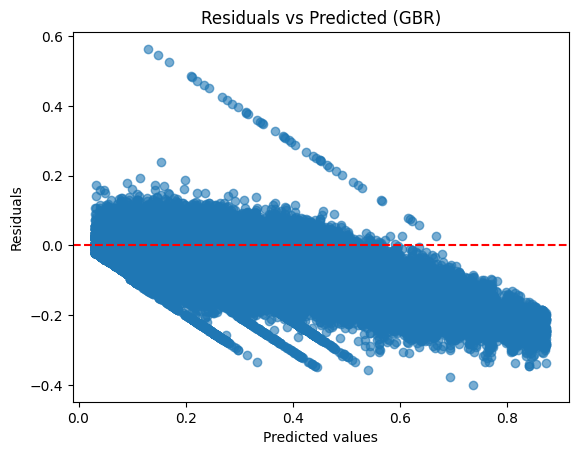

In [118]:
# plot residuals
y_resid_train = y_train - y_pred_train

plt.scatter(y_pred_train, y_resid_train, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (GBR)")
plt.show()

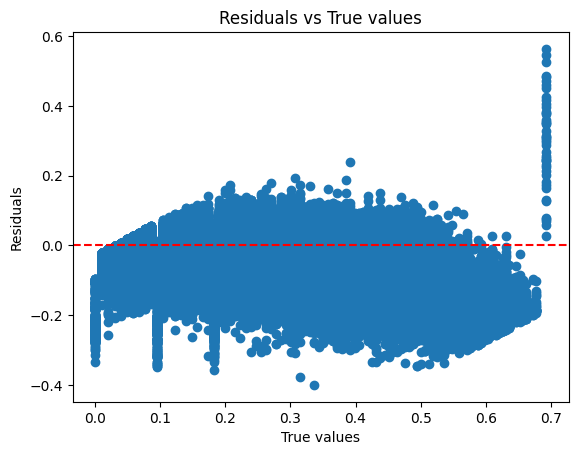

In [119]:
plt.scatter(y_train, y_resid_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True values")
plt.ylabel("Residuals")
plt.title("Residuals vs True values")
plt.show()

In [109]:
pre = model.named_steps["preprocessor"]
feature_names = pre.get_feature_names_out()  # e.g. ["num__curvature", "cat__weather=rain", ...]

# 2) Get impurity importances from the forest
rf = model.named_steps["gbr"]          # or ["model"] if you named it that way
importances = rf.feature_importances_

# 3) Make a tidy table
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print(imp_df.sort_values("Importance", ascending=False).head(20))

                            Feature  Importance
2                 num__curv_x_spd60    0.436948
1                 num__curv_x_night    0.236384
0                    num__curvature    0.115044
6                cat__weather_foggy    0.041426
8     cat__is_accidents_over_2_True    0.039923
5               cat__lighting_night    0.039917
7                cat__weather_rainy    0.033032
3                num__night_x_spd60    0.031141
9  cat__is_speed_limit_over_60_True    0.025977
4                 cat__lighting_dim    0.000208


(array([ 5486., 12368., 20151., 22105., 30998., 43833., 41357., 31411.,
        33729., 27902., 19456., 16498.,  8120.,  8750.,  3749.,  2925.,
         1769.,   442.,   235.,    78.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

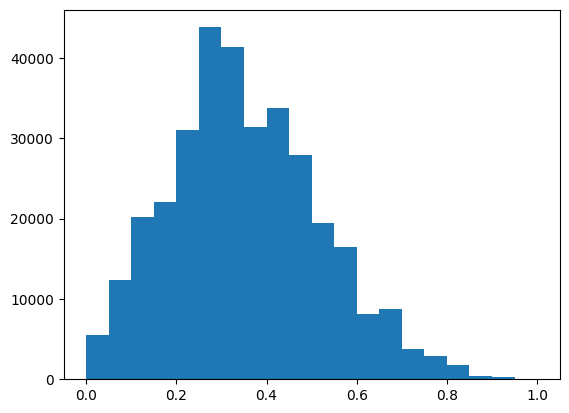

In [112]:
plt.hist(y_train, bins=20)

In [111]:
y_train.describe()

count    331362.000000
mean          0.352410
std           0.166355
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64



**TO DO**

Run permutation importance; confirm ranking.

 Drop lighting_dim and is_accidents_over_3; re-fit + log RMSE.

 Add interaction features; fit linear baseline and compare to RF.

 Parameterize thresholds and add to Hyperopt for RF/GBR.

 Boosting run with wider space; compare RMSE + slice errors.

 (Optional) Re-bin/collapse weather and re-evaluate.

### TO Do: playground emsemble

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor



num_features = ['curvature', 'curv_x_night', 'curv_x_spd60','night_x_spd60' ]
cat_features = ['lighting', 'weather']



cat_features = cat_features + ["is_speed_limit_over_40","is_accidents_over_2", "is_speed_limit_over_60"]


# Base pipeline A: numeric-only model
num_pre = ColumnTransformer(
    transformers=[("num", "passthrough", num_features)],
    remainder="drop"
)
num_model = Pipeline([
    ("pre_num", num_pre),
    ("model", Ridge(alpha=1.0, random_state=42))  # or ElasticNet
])

# Base pipeline B: categorical-only model
cat_pre = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)],
    remainder="drop"
)
cat_model = Pipeline([
    ("pre_cat", cat_pre),
    ("model", GradientBoostingRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42
    ))
])

# Stacking: learn how to combine A and B
stack = StackingRegressor(
    estimators=[("num", num_model), ("cat", cat_model)],
    final_estimator=Ridge(alpha=1.0, random_state=42),  # meta-learner
    cv=5, passthrough=False
)




In [68]:
# Fit/evaluate
stack.fit(X_train, y_train)
pred = stack.predict(X_train)
rmse = root_mean_squared_error(y_train, pred)
print(f"Stacking RMSE: {rmse:.4f}")

Stacking RMSE: 0.0738


In [69]:
# base learner that used only numeric features
num_pipe = stack.named_estimators_["num"]              # Pipeline(pre_num -> Ridge)
num_feat = num_pipe.named_steps["pre_num"].get_feature_names_out()
num_coef = num_pipe.named_steps["model"].coef_

import pandas as pd
coef_num_df = pd.DataFrame({"Feature": num_feat, "Coefficient": num_coef})
print(coef_num_df.sort_values("Coefficient", ascending=False))


              Feature  Coefficient
1   num__curv_x_night     0.254351
2   num__curv_x_spd60     0.250620
0      num__curvature     0.157018
3  num__night_x_spd60     0.060191


In [70]:
# base learner that used only categorical features
cat_pipe = stack.named_estimators_["cat"]              # Pipeline(pre_cat -> GBR/RF)
cat_feat = cat_pipe.named_steps["pre_cat"].get_feature_names_out()
cat_imp  = cat_pipe.named_steps["model"].feature_importances_

imp_cat_df = pd.DataFrame({"Feature": cat_feat, "Importance": cat_imp}) \
               .sort_values("Importance", ascending=False)
print(imp_cat_df.head(20))


                            Feature  Importance
1               cat__lighting_night    0.404521
6  cat__is_speed_limit_over_60_True    0.368348
5     cat__is_accidents_over_2_True    0.130968
2                cat__weather_foggy    0.050270
3                cat__weather_rainy    0.045567
4  cat__is_speed_limit_over_40_True    0.000248
0                 cat__lighting_dim    0.000078


In [71]:
# If your final_estimator is a bare Ridge/LinearRegression:
final_est = stack.final_estimator_
meta_coef = getattr(final_est, "coef_", None)
print(pd.Series(meta_coef, index=["num_pred", "cat_pred"]))



num_pred    0.638220
cat_pred    0.548515
dtype: float64


In [73]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    stack, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring=lambda est, X, y: -root_mean_squared_error(y, est.predict(X))
)

In [74]:
print(perm)

{'importances_mean': array([ 2.29539433e-02,  1.28996855e-02,  1.73753184e-05,  9.91191214e-03,
        2.46039886e-02,  1.72019563e-02,  1.96781055e-02,  2.26173663e-02,
       -7.22537803e-04]), 'importances_std': array([1.24680201e-04, 7.10404808e-05, 4.69936968e-06, 5.17918744e-05,
       1.33692496e-04, 1.08131730e-04, 1.15287870e-04, 1.18774479e-04,
       2.78146084e-05]), 'importances': array([[ 2.29753757e-02,  2.30188124e-02,  2.31518811e-02,
         2.28367719e-02,  2.29574110e-02,  2.27226974e-02,
         2.30642244e-02,  2.28650500e-02,  2.30821217e-02,
         2.28650877e-02],
       [ 1.28301928e-02,  1.29789033e-02,  1.30048154e-02,
         1.29163440e-02,  1.28648874e-02,  1.28511244e-02,
         1.29328046e-02,  1.27641461e-02,  1.28848443e-02,
         1.29687930e-02],
       [ 2.25011742e-05,  1.56715529e-05,  2.12522389e-05,
         1.07295284e-05,  2.02741408e-05,  1.67759447e-05,
         1.62310885e-05,  2.56449844e-05,  1.36057806e-05,
         1.10667504

**Notes:**

- For low-risk cases, the model is quite confident (residuals are small).
- For high-risk cases, it tends to underpredict the true values (positive residuals dominate at the top).